# Exploratory Analysis of E-Commerce Cosmetics Dataset

## Importing Required Libraries

In [1]:
import dask.dataframe as dd
from dask_ml.impute import SimpleImputer
import pandas as pd
import os
from scipy import stats
import numpy as np
from glob import glob
import missingno
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import seaborn as sns

import matplotlib.pyplot as plt
import cufflinks as cf

from plotly.offline import iplot, init_notebook_mode
init_notebook_mode(connected=True)
cf.go_offline(connected=True)
# SETTING THE THEME IN CUFFLINKS
cf.set_config_file(theme='pearl')

## Setup Dask

In [2]:
from dask.distributed import Client

client = Client(n_workers=8, threads_per_worker = 2)
client

Client Scheduler: tcp://127.0.0.1:59783 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 16 Memory: 17.00 GB


## Load Data

### Overview ::
The dataset consists of behaviour data of an e-commerce online store for the duration of 5 months (Oct. 2019 - Feb. 2020). The data consists of columns event_id, product_id, category_id, category_code, price, brand, user_id and user_session. The aim of our analysis is to get an overview of the behaviour of the customers which might be helpful in future for setting prices for items and other productions.


Read data from '.csv' files.

In [3]:
filenames = sorted(glob('*.csv'))
data = dd.read_csv(filenames,parse_dates=['event_time'])

data = data.drop(["user_session", "category_code"], axis=1)



In [4]:
df = data#.sample(frac = 0.02)

In [5]:

data = client.persist(data)

In [6]:
data.info()

<class 'dask.dataframe.core.DataFrame'>
Columns: 7 entries, event_time to user_id
dtypes: datetime64[ns, UTC](1), object(2), float64(1), int64(3)

In [7]:
df.compute().describe()

,product_id,category_id,price,user_id
count,2.069284e+07,2.069284e+07,2.069284e+07,2.069284e+07
mean,5.484297e+06,1.554230e+18,8.534735e+00,5.215527e+08
std,1.305716e+06,1.691038e+17,1.938142e+01,8.744312e+07
min,3.752000e+03,1.487580e+18,-7.937000e+01,4.654960e+05
25%,5.724650e+06,1.487580e+18,2.060000e+00,4.818306e+08
50%,5.810720e+06,1.487580e+18,4.050000e+00,5.531297e+08
75%,5.857864e+06,1.487580e+18,7.060000e+00,5.788573e+08
max,5.932595e+06,2.242903e+18,3.277800e+02,6.220902e+08


In [8]:
df.isnull().sum().compute()

event_time           0
event_type           0
product_id           0
category_id          0
brand          8757117
price                0
user_id              0
dtype: int64

### Data Correlation

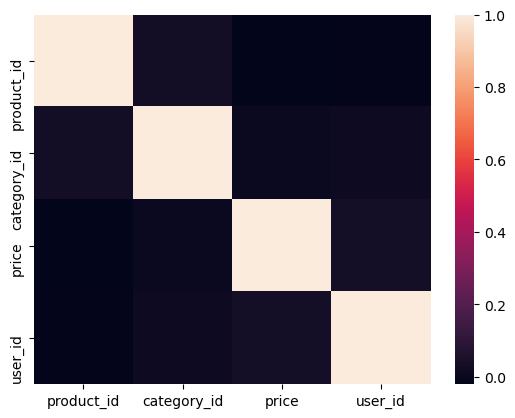

In [9]:
sns.heatmap(df.corr().compute())
plt.show()

### Missing Data

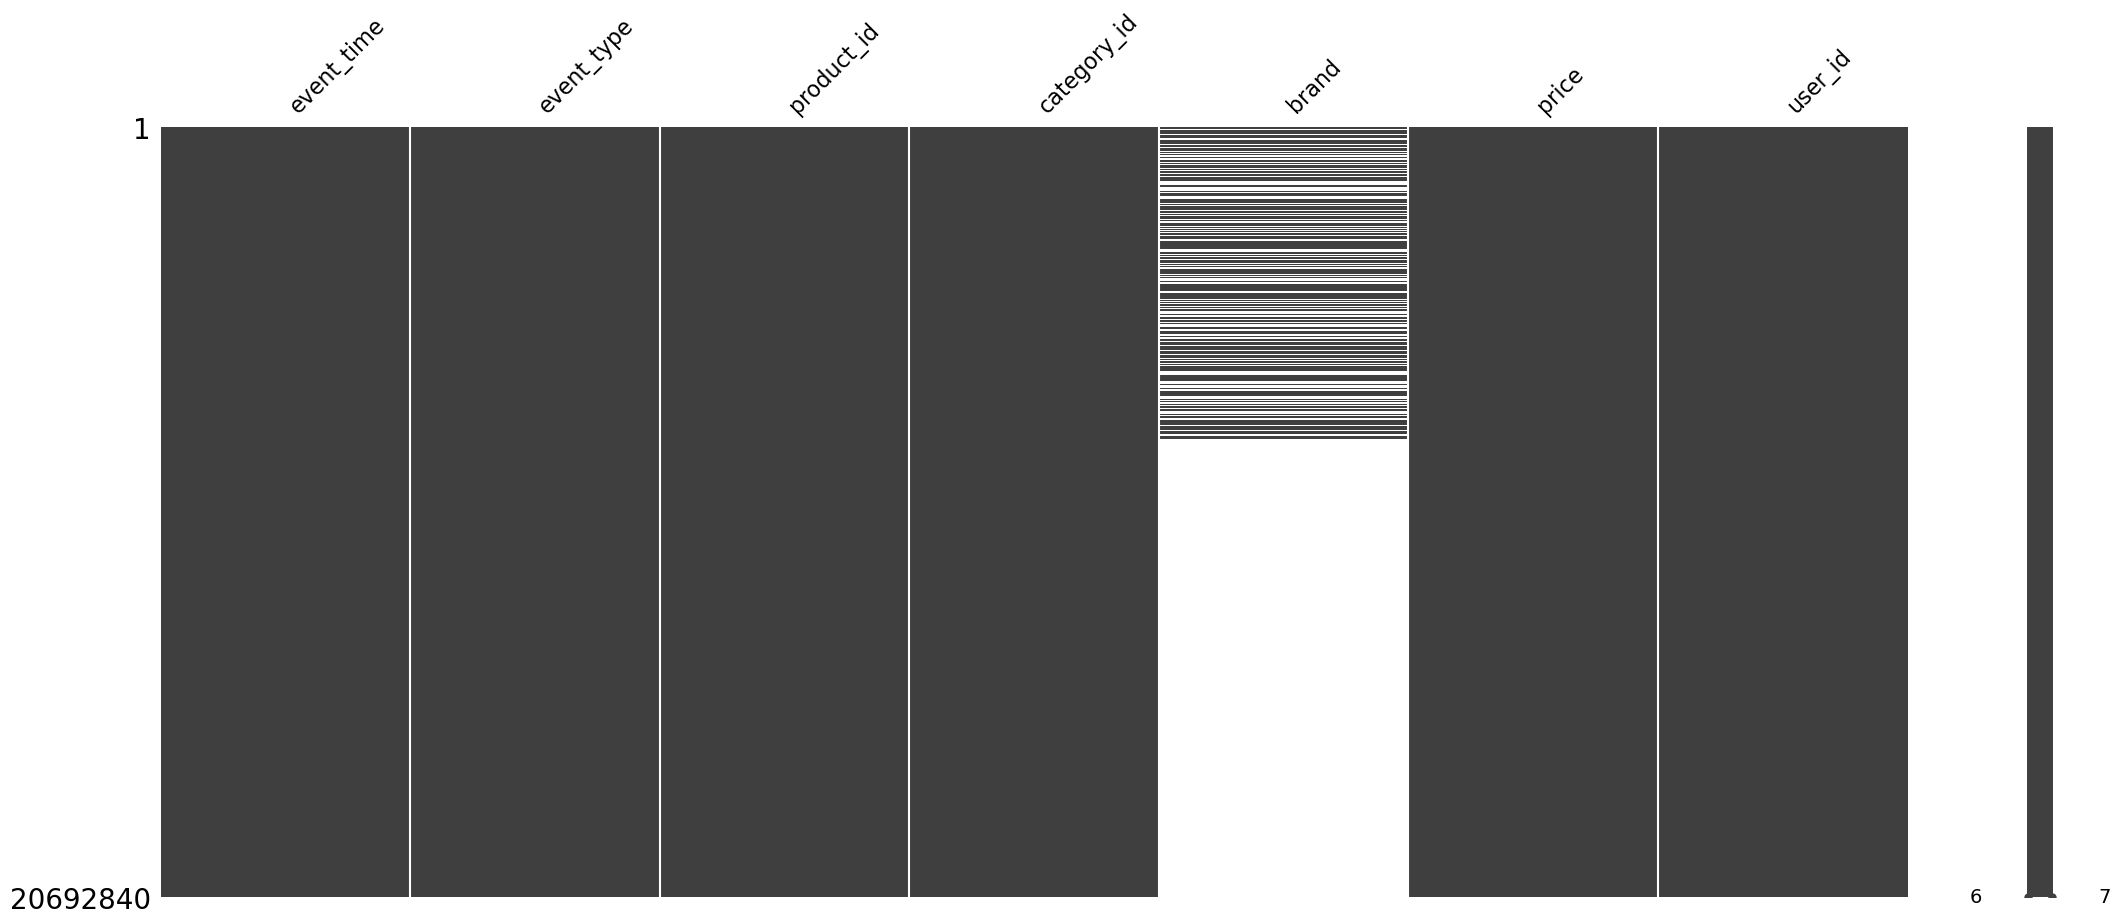

In [10]:
missingno.matrix(df.compute())
plt.show()

In [11]:
df = df.dropna()

## Exploratory Analysis

###  Average User Activity

We start the exploratory analysis by looking at average activity of unique users. We want to understand which year the users were more active, which months or days of week they are active, and so on.

    - Dipro Mondal

In [12]:
data_time_index = df.copy()
data_time_index = data_time_index.set_index('event_time')

month_evnt_type = data_time_index.groupby([data_time_index.index.month, data_time_index.event_type]).mean().compute()
year_evnt_type = data_time_index.groupby([data_time_index.index.year, data_time_index.event_type]).mean().compute()
daywk_evnt_type = data_time_index.groupby([data_time_index.index.dayofweek, data_time_index.event_type]).mean().compute()
dayhr_evnt_type = data_time_index.groupby([data_time_index.index.hour, data_time_index.event_type]).mean().compute()

In [192]:
mtdaywk_evnt_type = data_time_index.groupby([data_time_index.index.month, data_time_index.index.dayofweek, data_time_index.event_type]).mean().compute()

In [120]:
fig = px.bar(year_evnt_type['user_id'].unstack(), barmode="group",
      title="Average monthly activity by number of users",
             labels={"event_time": "Years",
              "value": "Number of Users"},
      color_discrete_sequence=px.colors.sequential.Greys)
fig.update_xaxes(type='category')

In [119]:
fig = px.bar(month_evnt_type['user_id'].unstack(),
      title="Average monthly activity by number of users",
             labels={"event_time": "Months",
              "value": "Number of Users"},
      color_discrete_sequence=px.colors.sequential.Greys)
fig = fig.update_xaxes(type='category', categoryarray= ['10','11','12','1','2']);


fig = fig.update_xaxes(tickangle=45,
                 tickmode = 'array',
                 tickvals = ['10', '11', '12', '1', '2'],
                 ticktext= ['Oct, 2019', 'Nov, 2019', 'Dec, 2019', 'Jan, 2020', 'Feb, 2020'])
fig.show()

Since we have 2 months from 2020 and 3 months from 2019, we did not need to group by the plots with years. 

In [121]:
fig = px.bar(daywk_evnt_type['user_id'].unstack(),
      title="Average monthly activity by number of users",
             labels={"event_time": "Days of Week",
              "value": "Number of Users"},
      color_discrete_sequence=px.colors.sequential.Greys)
fig = fig.update_xaxes(type='category')

fig = fig.update_xaxes(tickangle=0,
                 tickmode = 'array',
                 tickvals = ['0', '1', '2', '3', '4', '5', '6'],
                 ticktext= ['Mon', 'Tue', 'Wed', 'Thr', 'Fri', 'Sat', 'Sun'])
fig.show()

In [223]:
px.bar(pd.concat([daywk_evnt_type['user_id'].unstack()[0:4].mean(axis=0),
           daywk_evnt_type['user_id'].unstack()[5:].mean(axis=0)],keys=['Weekdays', 'Weekends'],
         axis=1),
      barmode="group",
       title="Average activity by number of users",
             labels={"event_time": "Days of Week",
              "value": "Number of Users",
              "variable": ""},
      color_discrete_sequence=px.colors.sequential.Greys)

In [122]:
fig = px.bar(dayhr_evnt_type['user_id'].unstack(),
      title="Average monthly activity by number of users",
      labels={"event_time": "Hours of a Day",
              "value": "Number of Users"},
      color_discrete_sequence=px.colors.sequential.Greys)
fig.update_xaxes(type='category')

The plots show there is not much variation in the user activity with respect to months or days of week. There is a slight increased activity in 2020 compared to 2019 probably because the start of pandemic.

### Average product range activity

We start the exploratory analysis by looking at average activity of unique users. We want to check the number of products browsed as a function of year, month and days of week.

    - Dipro Mondal

In [116]:
fig = px.bar(year_evnt_type['product_id'].unstack(), barmode ='group',
      title="Average yearly activity by products",
      labels={"event_time": "Years",
              "value": "Number of products"},
      color_discrete_sequence=px.colors.sequential.Greys)
fig.update_xaxes(type='category')

In [117]:
fig = px.bar(month_evnt_type['product_id'].unstack(),
      title="Average monthly activity by products",
             labels={"event_time": "Months",
              "value": "Number of products"},
      color_discrete_sequence=px.colors.sequential.Greys)
fig = fig.update_xaxes(type='category', categoryarray= ['10','11','12','1','2']);


fig = fig.update_xaxes(tickangle=45,
                 tickmode = 'array',
                 tickvals = ['10', '11', '12', '1', '2'],
                 ticktext= ['Oct, 2019', 'Nov, 2019', 'Dec, 2019', 'Jan, 2020', 'Feb, 2020'])

fig.show()

In [118]:
fig = px.bar(daywk_evnt_type['product_id'].unstack(),
      title="Average weekly activity by products",
      labels={"event_time": "Days of Week",
              "value": "Number of products"},
      color_discrete_sequence=px.colors.sequential.Greys)
fig = fig.update_xaxes(type='category')

fig = fig.update_xaxes(tickangle=0,
                 tickmode = 'array',
                 tickvals = ['0', '1', '2', '3', '4', '5', '6'],
                 ticktext= ['Mon', 'Tue', 'Wed', 'Thr', 'Fri', 'Sat', 'Sun'])
fig.show()

### Event Types
We notice that the 'Event Type' of the data are divided in to 4 groups - cart, purchase, view, remove_from_cart. Since we did not see much variation in the events with respect to users or product ids, we check if there is any variation in the differnt event types or not.

    - Abdulla Mamun

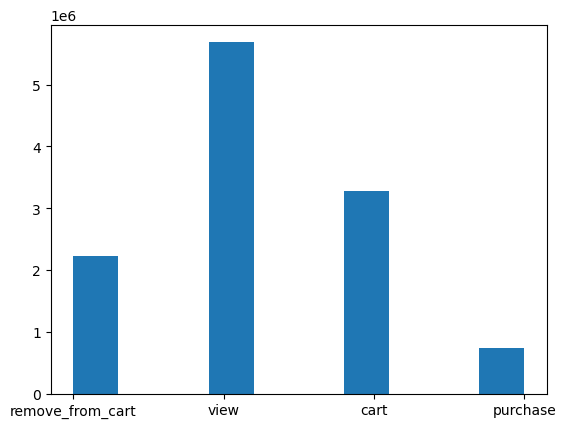

In [20]:
plt.hist(df["event_type"]);
plt.show()

### Price


The major column in any commerce dataset is the price column. We take a closer look at the price column.

    - Dipro

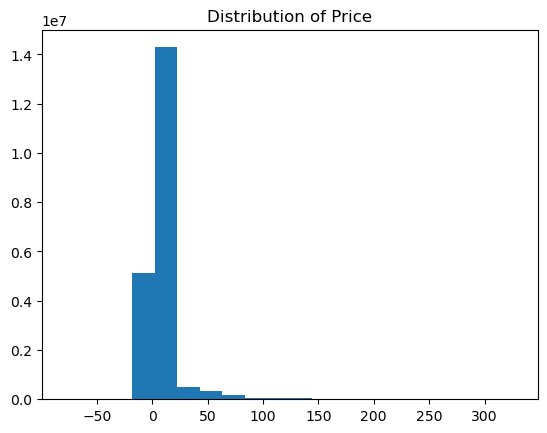

In [21]:
fig, ax = plt.subplots()
ax.hist(data.price, bins = 20);
ax.set_title("Distribution of Price")
plt.show()

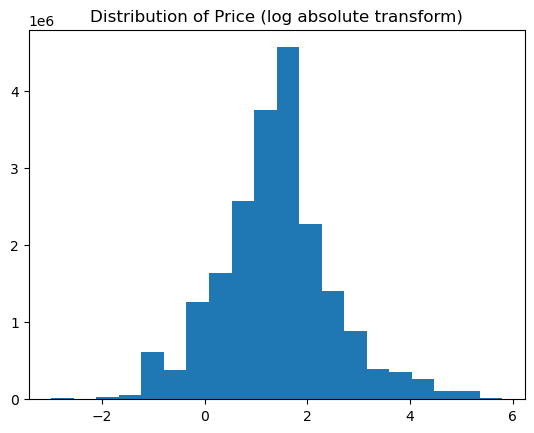

In [22]:
fig, ax = plt.subplots()
ax.hist([np.log(abs(x)) if x!=0 else 0 for x in data.price ], bins = 20);
ax.set_title("Distribution of Price (log absolute transform)")
plt.show()

In [23]:
qq = stats.probplot(df.price, dist='norm', sparams=(1))
x = np.array([qq[0][0][0], qq[0][0][-1]])

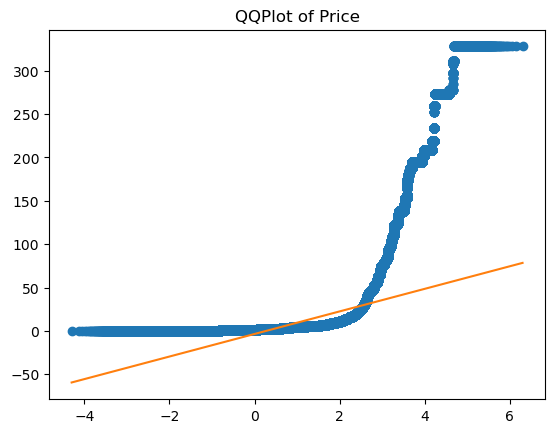

In [24]:
fig,ax = plt.subplots()
ax.plot(qq[0][0], qq[0][1], 'o')
ax.plot(x, qq[1][1] + qq[1][0]*x)
ax.set_title("QQPlot of Price")
plt.show()

The QQ plot suggest that the distribution of price is not at all normal (highly skewed to the right with more variation in the data than expected); we need some other distribution to represent this data.

In [25]:
print("Mean", np.mean(df.price.compute()),'\n', 
      "Sd : ", np.std(df.price.compute()),'\n', 
      "Mode : ", stats.mode(df.price.compute())[0][0], '\n')

Mean 9.469353306037675 
 Sd :  21.50687688152321 
 Mode :  5.24 



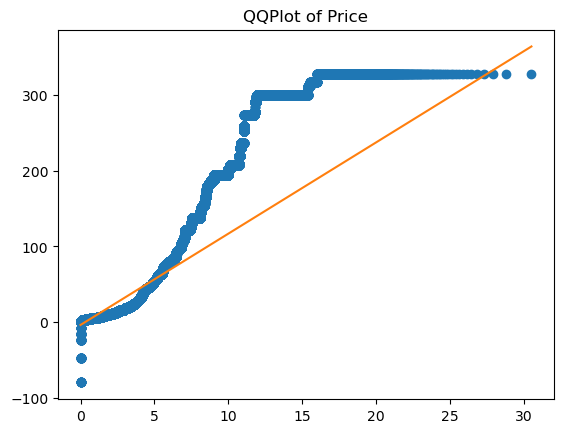

In [26]:
qq = stats.probplot(data.price, dist='chi2', sparams=(1))
x = np.array([qq[0][0][0], qq[0][0][-1]])
fig,ax = plt.subplots()
ax.plot(qq[0][0], qq[0][1], 'o')
ax.plot(x, qq[1][1] + qq[1][0]*x)
ax.set_title("QQPlot of Price")
plt.show()

The plot shows that there are more variations in the data than expected comparing to a Chisquare distribution. Even with some distributions we cannot get a good fit of the data, implying we have some considerable amount of outliers which needs to be removed. 

### Contingency table
Next, we check some correlations between the price and brand and event_types, with a contingency table
    
    - Marufa Akhter


In [83]:
cross_brand = pd.crosstab(data['brand'],data['price'],margins = True)

In [88]:
cross_brand.sort_values(by='All', ascending=False)[1:].head(10)

col_0,0.0,0.06,0.08,0.1,0.14,0.16,0.17,0.19,0.21,0.22,...,259.37,273.02,277.78,284.13,291.9,297.14,307.6,311.38,327.78,All
row_0,,,,,,,,,,,,,,,,,,,,,
runail,7,6297,0,0,1642,15,522,0,0,0,...,0,0,0,0,0,0,0,0,0,1528908
irisk,0,0,0,0,974,12119,0,54,531,286,...,0,0,0,0,0,0,0,0,0,1033852
masura,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,861763
grattol,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,852591
bpw.style,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,434813
ingarden,2,0,0,381,0,0,0,0,322,0,...,0,0,0,0,0,0,0,0,0,430958
estel,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,360912
kapous,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,324394
jessnail,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,252996


In [89]:
cross_brand.sort_values(by='All', ascending=True).head(10)

col_0,0.0,0.06,0.08,0.1,0.14,0.16,0.17,0.19,0.21,0.22,...,259.37,273.02,277.78,284.13,291.9,297.14,307.6,311.38,327.78,All
row_0,,,,,,,,,,,,,,,,,,,,,
pueen,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
gena,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
dessata,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6
vl-gel,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7
shifei,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9
voesh,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,11
footlogix,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,13
nova,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,14
invisibobble,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,16


In [82]:
pd.crosstab(data['event_type'],data['price'],margins = True)

col_0,-79.37,-47.62,-23.81,-15.87,-7.94,0.0,0.05,0.06,0.08,0.1,...,284.13,290.81,291.9,297.14,299.81,307.6,311.38,317.46,327.78,All
row_0,,,,,,,,,,,,,,,,,,,,,
cart,0,0,0,0,0,49370,1513,2512,2434,461,...,0,58,0,8,779,0,8,3,97,5768333
purchase,11,30,34,39,12,1,424,258,283,126,...,0,15,0,0,66,0,1,1,5,1287007
remove_from_cart,0,1,2,0,0,24296,670,916,658,229,...,0,48,0,1,575,0,4,4,64,3979679
view,1,0,1,0,0,30490,1194,2889,617,458,...,3,412,4,69,8375,12,108,341,1158,9657821
All,12,31,37,39,12,104157,3801,6575,3992,1274,...,3,533,4,78,9795,12,121,349,1324,20692840


### Removing Outliers
Based on what we saw in the modelling of the price, we want to check for outliers
  
    - Oanh

In [27]:
q25, q75 = np.percentile(df["price"], 25), np.percentile(df["price"], 75)
iqr = q75 - q25

In [28]:
print('Percentiles: 25th=%.3f, 75th=%.3f, IQR=%.3f' % (q25, q75, iqr))
# calculate the outlier cutoff
cut_off = iqr * 1.5
lower, upper = q25 - cut_off, q75 + cut_off
print("Range:",lower,upper)

outliers = [x for x in df["price"] if x < lower or x > upper]
print('Identified outliers: %d' % len(outliers))


Percentiles: 25th=2.210, 75th=7.140, IQR=4.930
Range: -5.185 14.535
Identified outliers: 1357358


In [30]:
new_price = [x for x in df["price"] if x >= lower and x <= upper]
print(len(new_price))
#df.drop(df[ (df.price > upper) | (df.price < lower) ])

df = df[(df.price >= lower) & (df.price <= upper)]

10578365


In [31]:
index = df[(df['price'] > upper)|(df['price'] < lower)].index

In [32]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity="all"

### Brand vs user_id 
Based on the users, we want to see which are the favoured or most spent brands

    -- Oanh

In [33]:
most_spent = df.groupby(["brand","user_id"])['price'].sum().nlargest(10).compute()
most_spent = pd.DataFrame(data=most_spent)
most_spent


price
brand    user_id            
trind    550388516  35257.16
         583884978  34982.21
uskusi   599365340  11831.73
trind    546625526   8761.19
beautix  551099180   8512.97
masura   459973546   8427.65
ingarden 524434718   7924.78
cnd      505752948   7265.44
beautix  451351553   6722.06
trind    484961283   6686.89

In [34]:
most_spent.iplot(kind="bar",
               title="The most spent users and the most spent brands",
                xTitle="Most popular brands and users",
               yTitle="Total money spent",
               legend=True,
               width=3, showlegend=True)

### Price difference with brands

Some brands are just overpriced. We want to see the distribution of brand versus price.

    - Marufa Akhter


In [35]:
price_brand = df.groupby(['brand'])['price'].sum().compute()

fig = px.bar(price_brand, title="Price differences in different brands")
fig.show()

### Price vs Category_id

We also check how the price depends on the different categories (category_id).

In [126]:
price_category_id = df.groupby(['category_id']).sum().compute().sort_values(by ='price', ascending=False)
p = df.groupby(["category_id"])["price"].sum().compute().nlargest(30).reset_index()

In [127]:
fig = px.bar(p, title="Price differences in different product category")
fig.show()

### Most and least expensive product_ids

The obvious followup question is to select the products which are more priced and ones which are least priced

    - Abdulla Mamun 

In [36]:
df["product_id"].value_counts().compute().head(10)

5809910    141590
5809912     55560
5700037     51037
5854897     44783
5751422     43175
5751383     43073
5849033     37559
5809911     36136
5816170     32185
5649236     25020
Name: product_id, dtype: int64

<Figure size 1500x1000 with 0 Axes>

<AxesSubplot:>

Text(0.5, 0, 'price')

Text(0, 0.5, 'product_id')

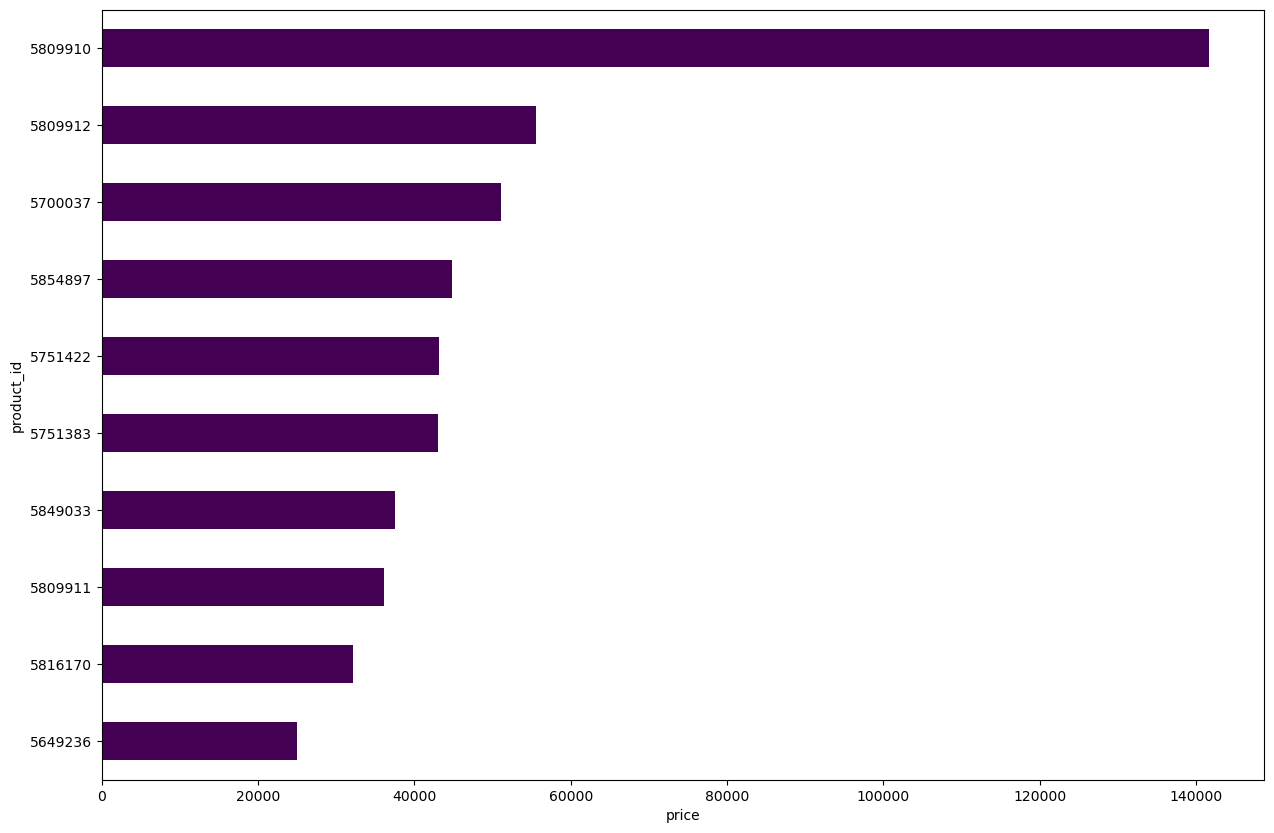

In [37]:
plt.figure(figsize=(15,10))
df["product_id"].value_counts().compute().head(10). sort_values(ascending = True).plot(kind = "barh", cmap = "viridis")
plt.xlabel("price")
plt.ylabel("product_id")
plt.show()

In [38]:
df["product_id"].value_counts().compute().tail(10)

5693959    1
5693876    1
5902308    1
5693873    1
5693848    1
5693195    1
5693192    1
5693179    1
5693169    1
5705028    1
Name: product_id, dtype: int64

In [39]:
plt.figure(figsize=(15,10))
df["product_id"].value_counts().compute().tail(10).plot(kind = "barh", cmap = "viridis")
plt.xlabel("price")
plt.ylabel("product_id");

In [40]:
min_, max_ = df.price.compute().min(), df.price.compute().max()
print(f"minimum price {min_} and maximum price {max_}")

minimum price 0.0 and maximum price 14.52


### Spenders

Next we look at the different users and identify the distribution among the top 10 users

     - Oanh

In [41]:
df['user_id'] = df['user_id'].astype(str)
spent_user = df.groupby(["user_id"])["price"].sum().nlargest(10).compute()
spent_user = pd.DataFrame(data=spent_user)

In [42]:
spent_user.iplot(kind="bar",
               title="The top 10 users spent money on cosmetics",
                xTitle="User ID",
               yTitle="Total money spent",
               legend=True,
               width=3, showlegend=True)